In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from pypfopt import BlackLittermanModel, plotting
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

# Load the hybrid generation results
with open('DiplomskiRadBlackLitterman/hybrid_generation_results.pkl', 'rb') as f:
    hybrid_results = pickle.load(f)

# Extract the important data
hybrid_weights = pd.DataFrame(hybrid_results['weights'])
assets = hybrid_results['assets']
start_date = pd.to_datetime(hybrid_results['start_date'])
end_date = pd.to_datetime(hybrid_results['end_date'])

print(f"Loaded hybrid results for {len(assets)} assets")
print(f"Period: {start_date} to {end_date}")
print(f"Assets: {', '.join(assets)}")

Loaded hybrid results for 8 assets
Period: 2019-01-01 00:00:00 to 2023-12-31 00:00:00
Assets: AAPL, MSFT, GOOGL, AMZN, JPM, JNJ, XOM, PG


In [5]:
data_start = start_date - pd.DateOffset(days=252)  # 1 year buffer for better covariance estimation
prices = yf.download(assets, start=data_start, end=end_date)['Close']

# Calculate returns
returns = prices.pct_change().dropna()

print(f"Downloaded price data: {len(prices)} days")
print(f"Price data shape: {prices.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  8 of 8 completed

Downloaded price data: 1432 days
Price data shape: (1432, 8)


In [42]:
custom_views = {
    'AAPL': (0.4, 0.75),   
    'MSFT': (0.3, 0.75),   
    'GOOGL': (0.20, 0.75),  
}

# Convert to the format needed for Black-Litterman
P = np.zeros((len(custom_views), len(assets)))
Q = []
omega_diag = []

for i, (asset, (view_return, confidence)) in enumerate(custom_views.items()):
    if asset in assets:
        asset_idx = assets.index(asset)
        P[i, asset_idx] = 1
        Q.append(view_return)
        # Convert confidence to uncertainty (variance of view)
        omega_diag.append((1 - confidence) * 0.1)  # Scale factor for uncertainty

Q = np.array(Q)
omega = np.diag(omega_diag)

print(f"Created {len(custom_views)} views")
print("Views:")
for asset, (ret, conf) in custom_views.items():
    print(f"  {asset}: {ret:.1%} return with {conf:.0%} confidence")

Created 3 views
Views:
  AAPL: 40.0% return with 75% confidence
  MSFT: 30.0% return with 75% confidence
  GOOGL: 20.0% return with 75% confidence


In [43]:
market_prices = prices.loc[start_date:end_date]
S = CovarianceShrinkage(market_prices).ledoit_wolf()

# For simplicity, use equal weights as "market weights"
# In practice, you'd use actual market cap weights
market_weights = np.array([1/len(assets)] * len(assets))
delta = 2.5  # Risk aversion parameter

# Calculate market-implied returns
market_implied_returns = delta * S.dot(market_weights)

# Apply Black-Litterman model
bl = BlackLittermanModel(S, pi=market_implied_returns, P=P, Q=Q, omega=omega)
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

print("Black-Litterman expected returns:")
for asset, ret in bl_returns.items():
    print(f"  {asset}: {ret:.2%}")

Black-Litterman expected returns:
  AAPL: 19.94%
  AMZN: 18.96%
  GOOGL: 18.30%
  JNJ: 7.65%
  JPM: 14.54%
  MSFT: 18.43%
  PG: 8.54%
  XOM: 12.33%


In [44]:
ef = EfficientFrontier(bl_returns, bl_cov)
ef.max_sharpe()
# ef.add_constraint(lambda w: w >= 0)  # Long-only constraint
# ef.add_constraint(lambda w: w <= 0.3)  # Max 30% in any asset

# Get optimal weights
custom_weights = ef.clean_weights()

# Convert to DataFrame for easier comparison
custom_weights_df = pd.DataFrame(index=hybrid_weights.index, columns=assets)
for asset in assets:
    custom_weights_df[asset] = custom_weights.get(asset, 0)

print("Optimal weights with custom views:")
for asset, weight in custom_weights.items():
    if weight > 0.01:
        print(f"  {asset}: {weight:.1%}")

Optimal weights with custom views:
  AAPL: 22.8%
  AMZN: 17.1%
  GOOGL: 11.2%
  JNJ: 9.8%
  JPM: 9.8%
  MSFT: 9.8%
  PG: 9.8%
  XOM: 9.8%


In [45]:
def calculate_portfolio_performance(weights_df, prices_df):
    """
    Calculate portfolio returns, volatility, and Sharpe ratio
    Handles cases where weights are only updated on rebalancing dates
    """
    # Calculate daily returns
    daily_returns = prices_df.pct_change().dropna()
    
    # Create a DataFrame to hold daily weights (forward-fill from rebalancing dates)
    daily_weights = pd.DataFrame(index=daily_returns.index, columns=weights_df.columns)
    
    # Forward fill weights from rebalancing dates
    for date in weights_df.index:
        if date in daily_weights.index:
            daily_weights.loc[date] = weights_df.loc[date]
    
    # Forward fill to propagate weights until next rebalancing
    daily_weights = daily_weights.fillna(method='ffill')
    
    # Drop any remaining NaN rows at the beginning
    daily_weights = daily_weights.dropna()
    
    # Align returns and weights
    common_dates = daily_returns.index.intersection(daily_weights.index)
    aligned_returns = daily_returns.loc[common_dates]
    aligned_weights = daily_weights.loc[common_dates]
    
    # Calculate portfolio returns
    portfolio_returns = (aligned_returns * aligned_weights).sum(axis=1)
    
    # Calculate metrics
    annual_return = portfolio_returns.mean() * 252
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol if annual_vol > 0 else 0
    
    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()
    
    return {
        'returns': portfolio_returns,
        'cumulative_returns': cumulative_returns,
        'annual_return': annual_return,
        'annual_volatility': annual_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': calculate_max_drawdown(cumulative_returns)
    }

def calculate_max_drawdown(cumulative_returns):
    """Calculate maximum drawdown"""
    rolling_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    return drawdown.min()

# Calculate performance for both strategies
hybrid_performance = calculate_portfolio_performance(hybrid_weights, market_prices)
custom_performance = calculate_portfolio_performance(custom_weights_df, market_prices)

print("Performance Comparison:")
print("-" * 50)
print(f"{'Metric':<20} {'Hybrid':<15} {'Custom Views':<15}")
print("-" * 50)
print(f"{'Annual Return':<20} {hybrid_performance['annual_return']:>14.2%} {custom_performance['annual_return']:>14.2%}")
print(f"{'Annual Volatility':<20} {hybrid_performance['annual_volatility']:>14.2%} {custom_performance['annual_volatility']:>14.2%}")
print(f"{'Sharpe Ratio':<20} {hybrid_performance['sharpe_ratio']:>14.2f} {custom_performance['sharpe_ratio']:>14.2f}")
print(f"{'Max Drawdown':<20} {hybrid_performance['max_drawdown']:>14.2%} {custom_performance['max_drawdown']:>14.2%}")

# Additional diagnostic information
print(f"\nPortfolio Statistics:")
print(f"Hybrid - Days of returns: {len(hybrid_performance['returns'])}")
print(f"Custom - Days of returns: {len(custom_performance['returns'])}")
print(f"Hybrid - Final cumulative return: {hybrid_performance['cumulative_returns'].iloc[-1] - 1:.2%}")
print(f"Custom - Final cumulative return: {custom_performance['cumulative_returns'].iloc[-1] - 1:.2%}")

Performance Comparison:
--------------------------------------------------
Metric               Hybrid          Custom Views   
--------------------------------------------------
Annual Return                30.93%         21.67%
Annual Volatility            29.83%         23.00%
Sharpe Ratio                   1.04           0.94
Max Drawdown                -39.23%        -29.14%

Portfolio Statistics:
Hybrid - Days of returns: 1168
Custom - Days of returns: 1168
Hybrid - Final cumulative return: 241.05%
Custom - Final cumulative return: 141.44%


/var/folders/3g/v4rb1rj566z04094jzhv71_40000gn/T/ipykernel_36497/780196874.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_weights = daily_weights.fillna(method='ffill')
/var/folders/3g/v4rb1rj566z04094jzhv71_40000gn/T/ipykernel_36497/780196874.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  daily_weights = daily_weights.fillna(method='ffill')
/var/folders/3g/v4rb1rj566z04094jzhv71_40000gn/T/ipykernel_36497/780196874.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_weights = daily_weights.fillna(method='ffill')
/var/folders/3g/v4rb1rj566z04094jzhv71_40000gn/T/ipyk

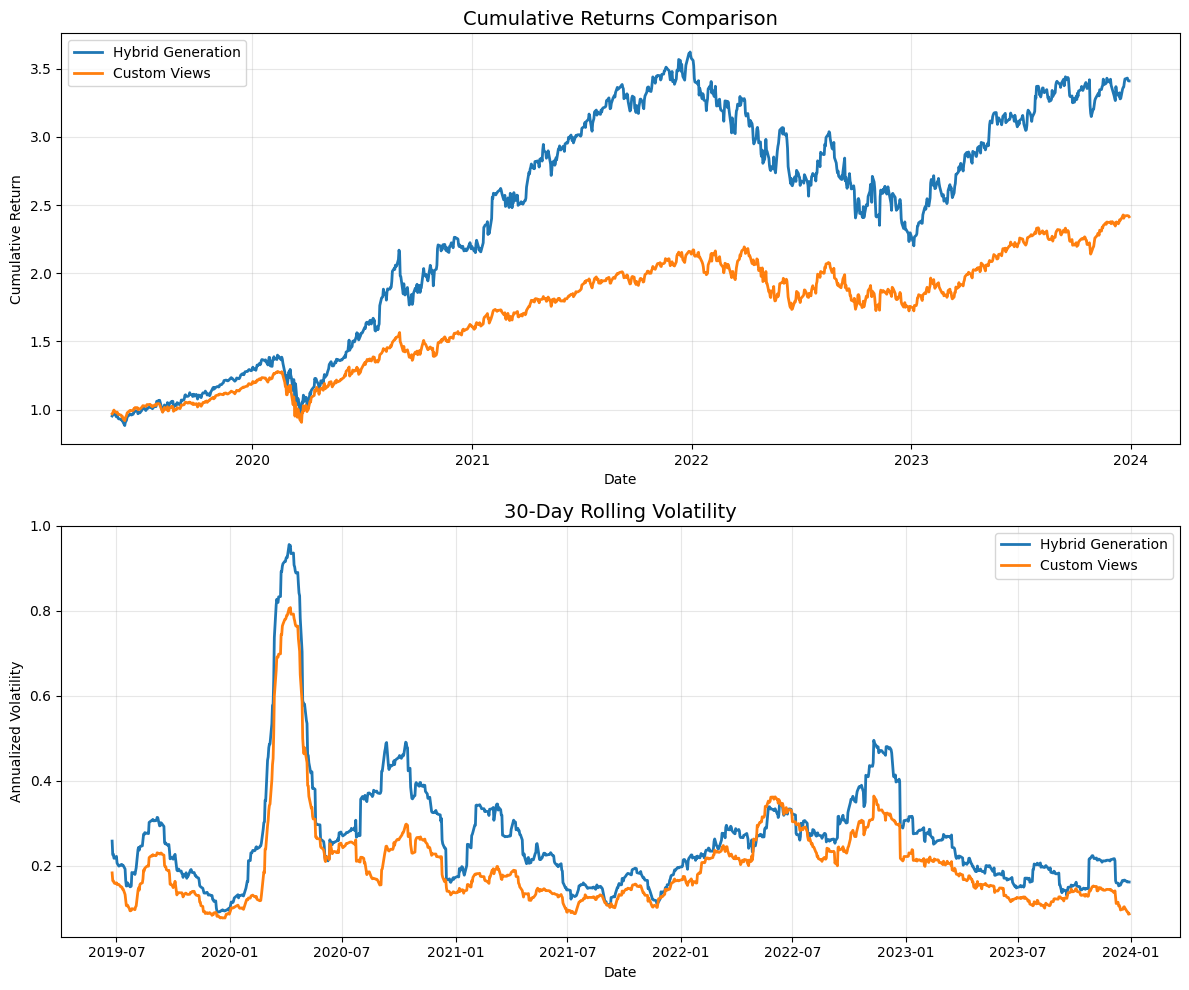

In [46]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot cumulative returns
ax1.plot(hybrid_performance['cumulative_returns'], label='Hybrid Generation', linewidth=2)
ax1.plot(custom_performance['cumulative_returns'], label='Custom Views', linewidth=2)
ax1.set_title('Cumulative Returns Comparison', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rolling volatility (30-day)
rolling_vol_hybrid = hybrid_performance['returns'].rolling(30).std() * np.sqrt(252)
rolling_vol_custom = custom_performance['returns'].rolling(30).std() * np.sqrt(252)

ax2.plot(rolling_vol_hybrid, label='Hybrid Generation', linewidth=2)
ax2.plot(rolling_vol_custom, label='Custom Views', linewidth=2)
ax2.set_title('30-Day Rolling Volatility', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Annualized Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

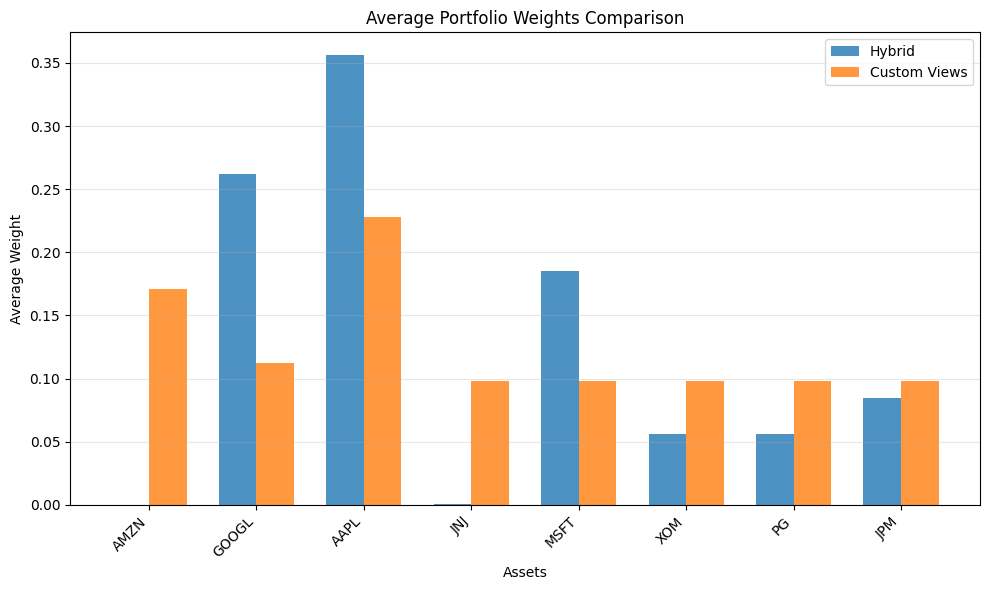


Weight Comparison (sorted by difference):
       Hybrid  Custom Views  Difference
AMZN    0.000         0.171       0.171
GOOGL   0.262         0.112      -0.150
AAPL    0.356         0.228      -0.129
JNJ     0.000         0.098       0.098
MSFT    0.185         0.098      -0.087
XOM     0.056         0.098       0.042
PG      0.056         0.098       0.042
JPM     0.085         0.098       0.013


In [47]:
# Calculate average weights for each strategy
avg_weights_hybrid = hybrid_weights.mean()
avg_weights_custom = custom_weights_df.mean()

# Create comparison DataFrame
weight_comparison = pd.DataFrame({
    'Hybrid': avg_weights_hybrid,
    'Custom Views': avg_weights_custom,
    'Difference': avg_weights_custom - avg_weights_hybrid
})

# Sort by absolute difference
weight_comparison = weight_comparison.sort_values('Difference', key=abs, ascending=False)

# Visualize weight differences
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(weight_comparison))
width = 0.35

bars1 = ax.bar(x - width/2, weight_comparison['Hybrid'], width, label='Hybrid', alpha=0.8)
bars2 = ax.bar(x + width/2, weight_comparison['Custom Views'], width, label='Custom Views', alpha=0.8)

ax.set_xlabel('Assets')
ax.set_ylabel('Average Weight')
ax.set_title('Average Portfolio Weights Comparison')
ax.set_xticks(x)
ax.set_xticklabels(weight_comparison.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nWeight Comparison (sorted by difference):")
print(weight_comparison.round(3))

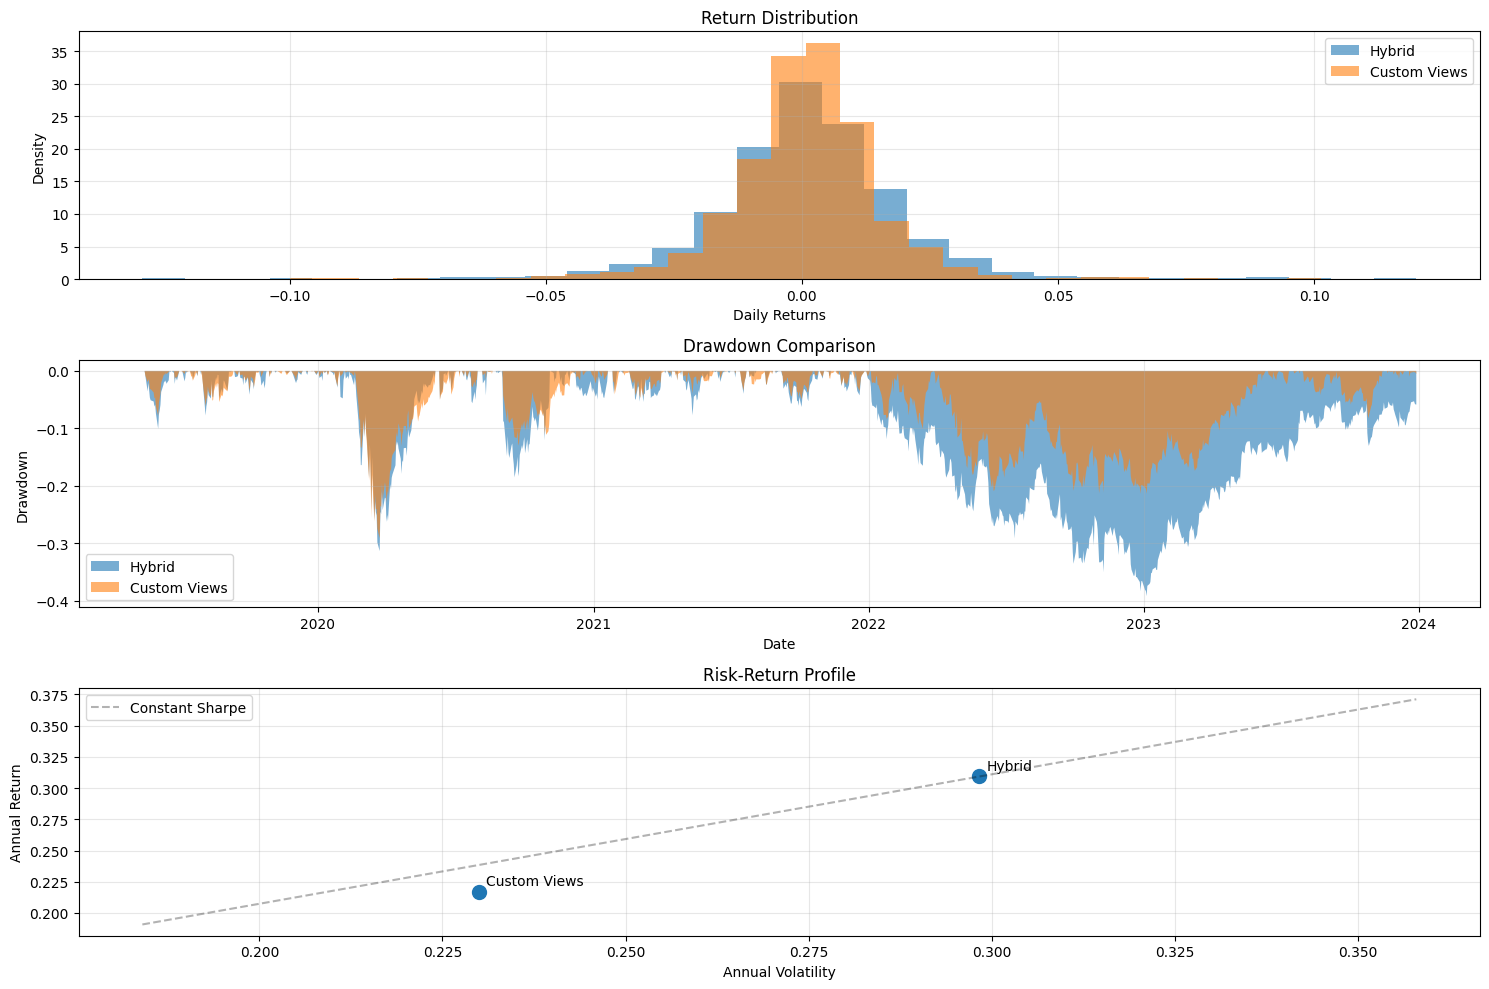

In [48]:
# Create a more detailed performance comparison
fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(15, 10))


# 1. Return distribution
ax1.hist(hybrid_performance['returns'], bins=30, alpha=0.6, label='Hybrid', density=True)
ax1.hist(custom_performance['returns'], bins=30, alpha=0.6, label='Custom Views', density=True)
ax1.set_title('Return Distribution')
ax1.set_xlabel('Daily Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Drawdown comparison
drawdown_hybrid = (hybrid_performance['cumulative_returns'] - hybrid_performance['cumulative_returns'].expanding().max()) / hybrid_performance['cumulative_returns'].expanding().max()
drawdown_custom = (custom_performance['cumulative_returns'] - custom_performance['cumulative_returns'].expanding().max()) / custom_performance['cumulative_returns'].expanding().max()

ax2.fill_between(drawdown_hybrid.index, drawdown_hybrid, 0, alpha=0.6, label='Hybrid')
ax2.fill_between(drawdown_custom.index, drawdown_custom, 0, alpha=0.6, label='Custom Views')
ax2.set_title('Drawdown Comparison')
ax2.set_xlabel('Date')
ax2.set_ylabel('Drawdown')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Risk-Return scatter
strategies = ['Hybrid', 'Custom Views']
returns = [hybrid_performance['annual_return'], custom_performance['annual_return']]
volatilities = [hybrid_performance['annual_volatility'], custom_performance['annual_volatility']]

ax3.scatter(volatilities, returns, s=100)
for i, strategy in enumerate(strategies):
    ax3.annotate(strategy, (volatilities[i], returns[i]), xytext=(5, 5), textcoords='offset points')

ax3.set_xlabel('Annual Volatility')
ax3.set_ylabel('Annual Return')
ax3.set_title('Risk-Return Profile')
ax3.grid(True, alpha=0.3)

# Add efficient frontier line (approximate)
x_vol = np.linspace(min(volatilities) * 0.8, max(volatilities) * 1.2, 100)
y_ret = x_vol * (returns[0] / volatilities[0])  # Approximate Sharpe ratio line
ax3.plot(x_vol, y_ret, 'k--', alpha=0.3, label='Constant Sharpe')
ax3.legend()

plt.tight_layout()
plt.show()

In [54]:
# Calculate additional metrics for comparison
def calculate_information_ratio(strategy_returns, benchmark_returns):
    """Calculate information ratio"""
    excess_returns = strategy_returns - benchmark_returns
    tracking_error = excess_returns.std() * np.sqrt(252)
    return excess_returns.mean() * 252 / tracking_error if tracking_error > 0 else 0

# Use hybrid as benchmark
info_ratio = calculate_information_ratio(custom_performance['returns'], hybrid_performance['returns'])

# Calculate win rate (days when custom outperforms hybrid)
win_rate = (custom_performance['returns'] > hybrid_performance['returns']).mean()

# Create final summary
summary = f"""
=== STRATEGY COMPARISON SUMMARY ===

Performance Metrics:
- Hybrid strategy outperformed Custom Views by: {( - custom_performance['annual_return'] + hybrid_performance['annual_return'])*100:.1f} bps annually
- Win Rate of Custom Views (daily): {win_rate:.1%}

Risk Metrics:
- Volatility difference: {(- custom_performance['annual_volatility'] + hybrid_performance['annual_volatility'])*100:.1f} bps
- Max Drawdown difference: {(custom_performance['max_drawdown'] - hybrid_performance['max_drawdown'])*100:.1f} bps

Key Insights:
1. {"Custom Views strategy shows higher risk-adjusted returns" if custom_performance['sharpe_ratio'] > hybrid_performance['sharpe_ratio'] else "Hybrid strategy shows higher risk-adjusted returns"}
2. {"Custom Views has lower volatility" if custom_performance['annual_volatility'] < hybrid_performance['annual_volatility'] else "Hybrid has lower volatility"}
3. {"Custom Views has better downside protection" if custom_performance['max_drawdown'] > hybrid_performance['max_drawdown'] else "Hybrid has better downside protection"}
"""

print(summary)


=== STRATEGY COMPARISON SUMMARY ===

Performance Metrics:
- Hybrid strategy outperformed Custom Views by: 9.3 bps annually
- Win Rate of Custom Views (daily): 49.1%

Risk Metrics:
- Volatility difference: 6.8 bps
- Max Drawdown difference: 10.1 bps

Key Insights:
1. Hybrid strategy shows higher risk-adjusted returns
2. Custom Views has lower volatility
3. Custom Views has better downside protection

